In [1]:
## Bring in needed mods
import pandas as pd, numpy as np, glob

## Load in matplot lib for plotting
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Load gff
## Set path to gff file
gff_path = '../DATA/XL280_NP_NUCLEAR_FINAL_gff.csv.gz'

## load gff path
gff = pd.read_csv(gff_path)

## Set contig, start, and end
gff['Contig'] = [ int(a.split('Chr')[-1]) for a in gff.chrom]
gff['Start'] = gff[['Zstart','Zend']].T.min()
gff['End'] = gff[['Zstart','Zend']].T.max()

## Sort values by start position and reset index
gff.sort_values(['Contig','Start'],inplace=True)
gff.reset_index(drop=True)

## print shape
gff.shape

(118827, 13)

In [3]:
## View head
gff.head()

,chrom,source,type,score,strand,phase,attribute,ID,Zstart,Zend,Contig,Start,End
118045,XL280_Chr01,1,gene,0.870529,+,.,ID=CNA00010;description=expressed protein,CNA00010,3238,4635,1,3238,4635
118046,XL280_Chr01,1,mRNA,0.870529,+,.,ID=CNA00010-t26_1;Parent=CNA00010;description=...,CNA00010,3238,4635,1,3238,4635
118047,XL280_Chr01,1,exon,0.870529,+,.,ID=exon_CNA00010-E1;Parent=CNA00010-t26_1,CNA00010,3238,3577,1,3238,3577
118058,XL280_Chr01,1,five_prime_UTR,0.870529,+,.,ID=utr_CNA00010-t26_1_1;Parent=CNA00010-t26_1,CNA00010,3238,3312,1,3238,3312
118053,XL280_Chr01,1,CDS,0.870529,+,0,ID=CNA00010-t26_1-p1-CDS1;Parent=CNA00010-t26_...,CNA00010,3313,3577,1,3313,3577


In [4]:
## Set columns of interest
columnsoi = ['chrom','Contig','strand','ID','Start','End','attribute']

## Take genes entries with a high blat score
genes = gff[(gff.type=='gene') & (gff.score>.9)].sort_values(['chrom','Start','strand'])[columnsoi].copy().reset_index(drop=True)

## remap strand
genes['Strand'] = genes.strand.replace(dict(zip(['+','-'],[1,-1])))

## View tail
genes.tail()

,chrom,Contig,strand,ID,Start,End,attribute,Strand
6922,XL280_Chr14,14,-,CNA08360,768315,770466,ID=CNA08360;description=hypothetical protein,-1
6923,XL280_Chr14,14,+,CNN02450,770735,772579,ID=CNN02450;description=unspecified product,1
6924,XL280_Chr14,14,+,CNN02455,772581,773982,ID=CNN02455;description=hypothetical protein,1
6925,XL280_Chr14,14,-,CNN02460,776003,778002,ID=CNN02460;description=retrotransposable elem...,-1
6926,XL280_Chr14,14,-,CNJ03440,778883,782075,ID=CNJ03440;description=conserved hypothetical...,-1


In [5]:
## Print shape
genes.shape

(6927, 8)

In [6]:
## Set the three type of gene orientations and 
## the numerical coding
types = ['Tandem','Divergent','Convergent']
types_num = [0,-2,2]

In [7]:
## Gather pair of genes by contigs
## initilize list
pairs = []

## Iterate thru the genes by contig
for i,c in genes.groupby('Contig'):
    
    ## Gather a temporary orientation
    orient_temp = c.Strand.values[:-1] - c.Strand.values[1:]
    
    ## Take the diff fo the start and end values
    diff = -(c.End.values[:-1] - c.Start.values[1:])
    
    ## Make the pairs by chromosomes
    chrom_pair = pd.DataFrame([c.chrom.values[:-1],c.ID.values[:-1],c.ID.values[1:],
                 c.Strand.values[:-1],c.Strand.values[1:],orient_temp,diff]).T
    
    ## Append to list
    pairs.append(chrom_pair)
    
## Concatonate dataframe
pairsdf = pd.concat(pairs)

## Set column names
pairsdf.columns = ['Contig','Left','Right','Lstrand','Rstrand','Orientation','Diff']

## Check that all genes where examined
assert pairsdf[~(pairsdf.Orientation.isin(types_num))].shape[0] == 0

## View a subset with orientation
pairsdf[(pairsdf.Orientation.isin(types_num))].head()

,Contig,Left,Right,Lstrand,Rstrand,Orientation,Diff
0,XL280_Chr01,CNA00020,CNA00030,-1,1,-2,636
1,XL280_Chr01,CNA00030,CNA00040,1,-1,2,1310
2,XL280_Chr01,CNA00040,CNA00050,-1,1,-2,170
3,XL280_Chr01,CNA00050,CNA00060,1,-1,2,-1715
4,XL280_Chr01,CNA00060,CNA00070,-1,1,-2,149


In [8]:
## Print totals per gene orientation group
print('Totals')

## Initilize list
type_total = []

## Iterate thru the coding
for i,a in enumerate(types_num):
    
    ## Count the coding
    k = pairsdf[(pairsdf.Orientation==a)].shape[0]  
    
    ## Print the resluts
    print('%s: %s'%(types[i],k))
    
    ## Append result
    type_total.append(k)

Totals
Tandem: 2448
Divergent: 2231
Convergent: 2234


In [9]:
## Set bin intervals
bins_ = [0,501,1001,1501,2001,2501,pairsdf.Diff.max()+1]

## Uncomment these lines to refine bin intervals
#prebins = list(np.arange(0,600,100)+1)
#bins_ = prebins +[1001,1501,2001,2501,pairsdf.Diff.max()+1]

In [10]:
## Count the number of genes given an orientation
## Segregate by distance between gene
## Initlize list
type_count = []

## Iterate thru the types of orientation coding
for i,a in enumerate(types_num):
    
    ## Gather those with a temp orientation
    k = pairsdf[(pairsdf.Orientation==a)]
    
    ## Count by distance bweteen gene
    counts = [k[(k.Diff<0)].shape[0]] + [ k[(k.Diff>=bins_[j]) & (k.Diff<bins_[j+1])].shape[0] for j in range(len(bins_)-1)]
    
    ## Append count
    type_count.append(np.array(counts))

In [11]:
## Zip bins
pairbins = list(zip(bins_[:-1],list(np.array(bins_[1:]) - 1)))

## View paired bins
pairbins

[(0, 500),
 (501, 1000),
 (1001, 1500),
 (1501, 2000),
 (2001, 2500),
 (2501, 76355)]

In [12]:
## Make new pairs of bin labels with commas
## Initilzie list
new_pairs = []

## iterate thru the paired bins
for pair in pairbins:
    
    ## Initlize new pairs
    k = []
    
    ## Iterate thru pairs
    for p in pair:
        
        ## if the pairs are less than 1000
        if p < 1000:
            ## just append pair
            k.append(str(p))
            
        ## Other wise add a comma
        else:
            k.append(str(p)[0] + ','+ str(p)[1:])
            
    ## append
    new_pairs.append(k)
    
## Set overlapping intervals y-label
## Add overlapping and greater than last bin
## Format bins
new_ylabels = ['Overlapping'] + [ '%s - %s bp'%(b[0],b[1]) for b in new_pairs[:-1]]+ ['>%s bp'%new_pairs[-1][0]]

## Print lables
new_ylabels

['Overlapping',
 '0 - 500 bp',
 '501 - 1,000 bp',
 '1,001 - 1,500 bp',
 '1,501 - 2,000 bp',
 '2,001 - 2,500 bp',
 '>2,501 bp']

In [13]:
## Make a dataframe of type counts
## Set row names to the new yalbels from above
type_df = pd.DataFrame(type_count,columns=new_ylabels).T

## Set column names to the type of gene orientation
type_df.columns = types

## Save out dataframe
type_df.to_csv('../DATA/intergenic_distances_counts_XL280.csv');

## View dataframe
type_df

,Tandem,Divergent,Convergent
Overlapping,77,98,1335
0 - 500 bp,1539,1669,658
"501 - 1,000 bp",423,198,119
"1,001 - 1,500 bp",163,91,43
"1,501 - 2,000 bp",89,54,27
"2,001 - 2,500 bp",57,43,14
">2,501 bp",100,78,38


In [14]:
## Bring in blat resluts
T1_hits = pd.read_csv('../DATA/T1_XL280np_Results_viaBLAT.csv')

## Gather duplicates
dups = [i for (i,j) in T1_hits.iterrows() if (len(j.Name.split('cate-'))==2)]

## Drop them
T1_hits.drop(dups,axis=0,inplace=True)

## Print the shape
T1_hits.shape

(44, 10)

In [15]:
## View head
T1_hits.head()

,Name,Isolate,Sample,Passage,Chromosome,Gene1,Gene2,Left,Right,Notes
0,30-1,1,1,30,8,CNH02250,CNH02260,252052,257394,isoalte 1 sample 1 is the same as sample 2
2,30-2,1,3,30,2,CNB02620,CNB02630,784465,788398,between genes
3,30-2,1,3,30,3,CNC05220,CNC05230,1569343,1577198,within CNC05220
4,30-2,1,3,30,11,CNK03170,CNK03180,962281,967781,between genes
5,30-2,1,3,30,13,CNM02230,CNM02240,720108,725961,between genes


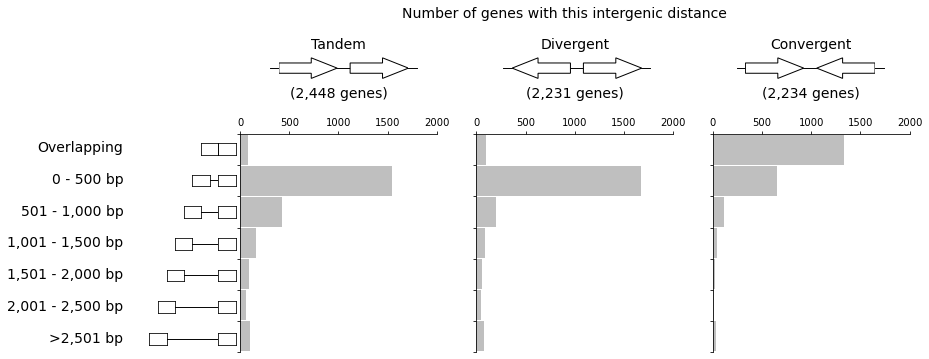

In [16]:
## Plot the distribution of gene orientation
## Call figure and set facecolor
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4));
fig.set_facecolor('w')

## Iterate thru type count
for i, b in enumerate(type_count):
    
    ## Set axis
    plt.sca(ax[i]);
    
    ## Reset x-ticks postions
    ax[i].xaxis.tick_top()
    
    ## SEt label and label postions
    ax[i].set_xlabel('X LABEL')    
    ax[i].xaxis.set_label_position('top') 
    
    ## REmove spoines
    [ax[i].spines[sp].set_visible(False) for sp in ['bottom','right']]

    ## ADd horizontal lines
    plt.hlines(np.arange(len(b))[::-1],np.zeros(len(b)),b,color='k',linewidth=30,alpha=0.25)
    
    ## Set x and ylimits and yticks
    plt.xlim(-1,2000)
    plt.ylim(-0.5,6.5)
    plt.yticks(np.arange(8) - 0.5,[])
    
    ## Add an xlabel
    plt.xlabel('%s\n\n\n(%s,%s genes)\n'%(types[i],str(type_total[i])[0],str(type_total[i])[1:]),fontsize=14)

## Draw genes
## For tandem
az = fig.add_axes([0.16,1.11,0.17,0.0001]);plt.xticks([]);plt.yticks([]) 
az = fig.add_axes([0.17,1.06,0.15,0.1]);plt.xticks([]);plt.yticks([]) 
plt.xlim(-1,1)
plt.ylim(-0.2,1.2)
az.arrow(-1, 0.5 , 0.5, 0, head_width=1, width=0.5, head_length=0.4, fc='w', ec='k')
az.arrow(0.1, 0.5, 0.5, 0, head_width=1, width=0.5, head_length=0.4, fc='w', ec='k')
plt.axis('off')

## For divergent
az = fig.add_axes([0.43,1.11,0.17,0.0001]);plt.xticks([]);plt.yticks([]) 
az = fig.add_axes([0.44,1.06,0.15,0.1]);#plt.xticks([]);plt.yticks([]) 
plt.xlim(-1,1)
plt.ylim(-0.2,1.2)
az.arrow(0.1, 0.5 , 0.5, 0, head_width=1, width=0.5, head_length=0.4, fc='w', ec='k')
az.arrow(-0.1, 0.5, -0.5, 0, head_width=1, width=0.5, head_length=0.4, fc='w', ec='k')
plt.axis('off')

## For convergent
az = fig.add_axes([0.70,1.11,0.17,0.0001]);plt.xticks([]);plt.yticks([]) 
az = fig.add_axes([0.71,1.06,0.15,0.1]);plt.xticks([]);plt.yticks([]) 
plt.xlim(-1,1)
plt.ylim(-0.2,1.2)
az.arrow(1, 0.5 , -0.5, 0, head_width=1, width=0.5, head_length=0.4, fc='w', ec='k')
az.arrow(-1, 0.5, 0.5, 0, head_width=1, width=0.5, head_length=0.4, fc='w', ec='k')
plt.axis('off')

## Add ylables of interavles
## Set axis
plt.sca(ax[0])

## Iterate thru the new ylables
for i in range(len(new_ylabels)):
    
    fig.add_axes([0.1-((i*.01)+0.02),0.83-(i*.11),0.0+(i/(25+(i*8))),0.000001]);plt.xticks([]);plt.yticks([]) 
    fig.add_axes([0.1,0.81-(i*.11),0.02,0.04]);plt.xticks([]);plt.yticks([]) 
    fig.add_axes([0.1-((i*.01)+0.02),0.81-(i*.11),0.02,0.04]);plt.xticks([]);plt.yticks([]) 
    
[fig.text(y = .82-(i*.11),x=-0.01,s =b,ha='right',fontsize=14) for i,b in enumerate(new_ylabels)];
fig.text(x=0.5,y=1.3,s='Number of genes with this intergenic distance',fontsize=14,va='center',ha='center');

## Save figure
plt.savefig('../FIGURES/Intergenic_distance_XL280_nanopore.png',dpi=300,bbox_inches='tight');